In [10]:
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras import optimizers

from keras.layers import Conv1D,Conv2D, MaxPooling1D,MaxPooling2D, Embedding
from keras.layers import Dense, Input, Flatten,Concatenate,merge, Dropout, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adadelta, RMSprop

from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import re
import string
from keras.utils import np_utils
import pandas as pd
import numpy as np

# Importing data form the stanford datasets and Cornell polarity files
fos  = 'original_rt_snippets.txt'
fp = 'rt-polarity.pos'
fn = 'rt-polarity.neg'
fall = pd.read_csv('datasetSentences.txt',sep = "\t",header = 0)
fsplit = pd.read_csv('datasetSplit.txt', delimiter = ",", header = 0)

#preprocessing data for comparing and other uses
def preprocessing(line):
    newline = line
    newline = newline.lower()
    newline = re.sub('<.*?>', '',newline)        
    newline = re.sub('<[a-zA-Z]','',newline)
    newline = re.sub(r'[^\w]','',newline)        
    newline = re.sub(r'[0-9]','',newline)        
    newline = re.sub(r'[^\x00-\x7f]','',newline)
    return newline
#Splitting lines fumction to store data
def wordstolist(line):
    newline = line
    newline = newline.lower()
    newline = re.sub(r'\d+', '', newline)
    newline = newline.translate(str.maketrans('', '', string.punctuation))
    newline = newline.strip()
    return newline
def filterlines(line):
    line= line.lower()
    line = re.sub(r'[^\w]','',line)
    line = re.sub(r'[0-9]','',line)
    line = re.sub(r'[^\x00-\x7f]','',line)
    line = line.replace("lrb", "")
    line = line.replace("rrb","")
    return line
  
    
sf = []
sp = []
sn = []
    
sf = []

#reading the data from original file and positive/negative files for comparision later
with open(fos, 'rt', encoding = 'latin-1') as f:
    for each_line in f:
        each_line = preprocessing(each_line) 
        sf.append(each_line)    
sp=[]
with open(fp,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = preprocessing(each_line)
        sp.append(each_line)
sn=[]
with open(fn,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = preprocessing(each_line)
        sn.append(each_line)


#Divinding and storing labels of lines based on their presence in Positive or negative
labelsall = []
for line in sf:
    if any(line == text for text in sp):
        labelsall.append(1)
    elif any(line == text for text in sn):
        labelsall.append(0)
        #Through by lot of preprocessing process we get to know that there is one sentence which doesn't belong to any of the files 
    elif line =="ihavenoproblemwithdifficultmoviesormoviesthatasktheaudiencetomeetthemhalfwayandconnectthedotsinsteadofhavingthingsallspelledoutbutfirstyouhavetogivetheaudienceareasontowanttoputforthateffort" :
#       print('new')
        labelsall.append(0)
    else:
        print (line)
        
#index finder
def indSent(sen,allsen):
    for ind in range(len(allsen)):
        if sen in allsen[ind]:
            return ind

        
labels=[]
for sent in list(fall["sentence"].values):
    sent= filterlines(sent)
    index = indSent(sent,sf)
    labels.append(labelsall[index])
    sf[index]= sf[index].replace(sent,"$$",1) 
fall["labels"]=labels

listall,listwords = [],[]
trainind,testind,devind=[],[],[]
totallabels,trainlabels,devlabels,testlabels=[],[],[],[]
    
for line in fall['sentence']:
    exclude = set(string.punctuation)
    line = ''.join(ch for ch in line if ch not in exclude)
    listwords=[]
    for word in line.split():
        listwords.append(word)
    listall.append(listwords)

#storing indexes which will be used later to find Labels
for k,i in enumerate(fsplit['splitset_label']):
    if i==1:
        trainind.append(k+1)
    if i==2:
        testind.append(k+1)
    if i==3:
        devind.append(k+1)
    
for i in fall['labels']:
    totallabels.append(i)

#creasting test dev train labels
for i in trainind:
    trainlabels.append(totallabels[i-1])
for i in devind:
    devlabels.append(totallabels[i-1])
for i in testind:
    testlabels.append(totallabels[i-1])
    
#Using tokenizer to find all words and max integers
tokenizer = Tokenizer()
# Calculating the frequency of words
tokenizer.fit_on_texts(listall)
# Convert array of sentences to list of sequences of integers
sequences = tokenizer.texts_to_sequences(listall)

# Dictionary keeping track of words to integer index
word_index = tokenizer.word_index

# Convert the array of sequences(of integers) to 2D array with padding
data = pad_sequences(sequences)
    
listtrain=[]
listdev=[]
listtest=[]

#creating train,dev,test lists of 2d arrays form data which will used as arrays later
for i in trainind:
    listtrain.append(list(data[i-1]))
for i in devind:
    listdev.append(list(data[i-1]))
for i in testind:
    listtest.append(list(data[i-1]))
    

In [11]:
#plotting function of history-loss and accuracy graphs of training and val/dev data 
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.plot(hist['epoch'], hist['acc'],
               label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],
               label = 'Val Accuracy')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
    plt.ylim([0,5])
    plt.legend()
    plt.show()   


In [12]:

def main(cnn_model,hiddenunits,seqlen,learningrate):
    embeddings_index = {}
    print("*************************************************************************")
    print( "Model = "+ str(cnn_model) + " hiddenunits = "+str(hiddenunits) +" seqlen=" + str(seqlen)+ " Learningrate="+ str(learningrate))


    f = open('glove.6B.300d.txt','rt',encoding = 'utf8')
    for line in f:
        values = line.split()
        word = values[0]
        #print(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close() 
    print('Found %s word vectors.' % len(embeddings_index))
    
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    #defining parameters       
    filtersize_list = [3, 4, 5]
    number_of_filters_per_filtersize = [100, 100, 100]
    pool_length_list = [2, 2, 2]
    dropout_list = [0.5, 0.5]
    optimizer = Adadelta(clipvalue=3)
    use_embeddings = True
    embeddings_trainable = False
    
    #Picking model according to arg
    if (cnn_model.lower() == 'cnn-rand'):
        use_embeddings = False
        embeddings_trainable = True
    elif (cnn_model.lower() == 'cnn-static'):
        pass
    elif (cnn_model.lower() == 'cnn-non-static'):
        embeddings_trainable = True
    else:
        filtersize_list = [3, 4, 5]
        number_of_filters_per_filtersize = [150, 150, 150]
        pool_length_list = [2, 2, 2]
        dropout_list = [0.25, 0.5]
        optimizer = RMSprop(lr=learning_rate)
        use_embeddings = True
        embeddings_trainable = True
        
    #deciding which embedding to use 
    if (use_embeddings):
        embedding_layer = Embedding(input_dim=(len(word_index) + 1), output_dim=300,
                                    weights = [embedding_matrix],
                                    input_length=52, trainable = embeddings_trainable)
    else:
        embedding_layer = Embedding(input_dim=(len(word_index) + 1), output_dim=300,
                                    weights = None,
                                    input_length=52, trainable = embeddings_trainable)

    print('Defining model.')

    #Designing the model 
    
    input_node = Inputs(shape=(52, 300))
    conv_list = []
    for index, filtersize in enumerate(filtersize_list):
        nb_filter = number_of_filters_per_filtersize[index]
        pool_length = pool_length_list[index]
        
        
        conv = Conv1D(nb_filter=nb_filter, filter_length=filtersize, activation='relu')(input_node)
        pool = MaxPooling1D(pool_length=pool_length)(conv)
        print(nb_filter,filtersize,pool_length,pool)
        flatten = Flatten()(pool)
        conv_list.append(flatten)

    if (len(filtersize_list) > 1):
        out = merge.concatenate(conv_list)
    else:
        out = conv_list[0]

    graph = Model(input=input_node, output=out)

    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(dropout_list[0], input_shape=(seqlen, 300)))
    model.add(graph)
    model.add(Dense(hiddenunits))
    model.add(Dropout(dropout_list[1]))
    model.add(Dense(1, activation='sigmoid'))
    adam = optimizers.Adam(lr = learningrate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    return model



*************************************************************************
Model = cnn-static hiddenunits = 150 seqlen=52 Learningrate=0.001
Found 400000 word vectors.
Defining model.


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=3)`
D:\anaconda\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


100 3 2 Tensor("max_pooling1d_34/Squeeze:0", shape=(?, 25, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=4)`


100 4 2 Tensor("max_pooling1d_35/Squeeze:0", shape=(?, 24, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=5)`


100 5 2 Tensor("max_pooling1d_36/Squeeze:0", shape=(?, 24, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 8544 samples, validate on 1101 samples
Epoch 1/4
 - 3s - loss: 1.3857 - acc: 0.5125 - val_loss: 0.7161 - val_acc: 0.5749
Epoch 2/4
 - 1s - loss: 0.7182 - acc: 0.5479 - val_loss: 0.6897 - val_acc: 0.5758
Epoch 3/4
 - 1s - loss: 0.6701 - acc: 0.6126 - val_loss: 0.6720 - val_acc: 0.6585
Epoch 4/4
 - 1s - loss: 0.6277 - acc: 0.6763 - val_loss: 0.6122 - val_acc: 0.6839


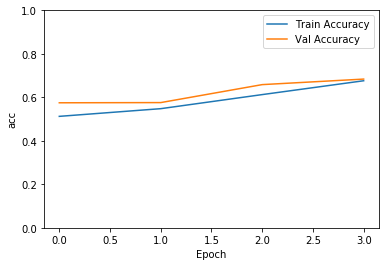

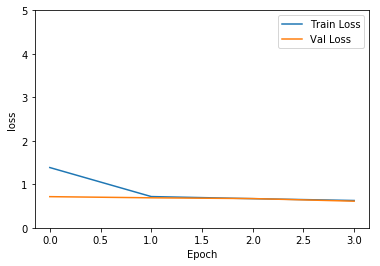

In [23]:
    #CNN Static Model wih hidden units = 150 and max seq = 52, and Learning rate =0.001  - - ignore warnings
    modelcnnstatic = main('cnn-static',150,52,0.001)
    history = modelcnnstatic.fit(np.array(listtrain), np.array(trainlabels), epochs=4,verbose=2, batch_size=512, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)

### CNN-Static
#### Our train accuracy: 67.63%, Val Accuracy: 68.39% -for Hidden units = 512, DIM =300 and sequence length = 52

*************************************************************************
Model = cnn-rand hiddenunits = 150 seqlen=52 Learningrate=0.001
Found 400000 word vectors.
Defining model.


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=3)`
D:\anaconda\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


100 3 2 Tensor("max_pooling1d_25/Squeeze:0", shape=(?, 25, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=4)`


100 4 2 Tensor("max_pooling1d_26/Squeeze:0", shape=(?, 24, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=5)`


100 5 2 Tensor("max_pooling1d_27/Squeeze:0", shape=(?, 24, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 8544 samples, validate on 1101 samples
Epoch 1/4
 - 3s - loss: 0.7227 - acc: 0.5076 - val_loss: 0.6907 - val_acc: 0.5086
Epoch 2/4
 - 1s - loss: 0.6756 - acc: 0.6018 - val_loss: 0.6741 - val_acc: 0.6421
Epoch 3/4
 - 2s - loss: 0.5833 - acc: 0.7403 - val_loss: 0.5813 - val_acc: 0.7003
Epoch 4/4
 - 1s - loss: 0.3538 - acc: 0.8511 - val_loss: 0.6441 - val_acc: 0.7039


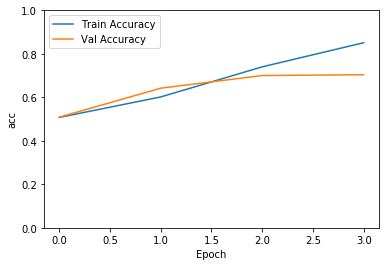

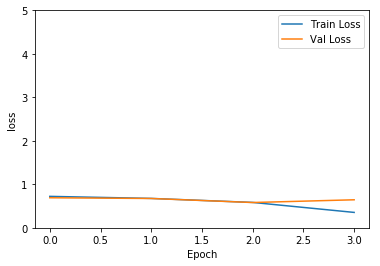

In [20]:
    #CNN Rand Model wih hidden units = 150 and max seq = 52, and Learning rate =0.001  - - ignore warnings
    modelcnnrand = main('cnn-rand',150,52,0.001)
    history = modelcnnrand.fit(np.array(listtrain), np.array(trainlabels), epochs=4,verbose=2, batch_size=512, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)

### CNN- Rand
#### Our train accuracy: 85.11%, Val Accuracy: 70.39% -for Hidden units = 512, DIM =300 and sequence length = 52

*************************************************************************
Model = cnn-non-static hiddenunits = 150 seqlen=52 Learningrate=0.001
Found 400000 word vectors.
Defining model.


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=3)`
D:\anaconda\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


100 3 2 Tensor("max_pooling1d_31/Squeeze:0", shape=(?, 25, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=4)`


100 4 2 Tensor("max_pooling1d_32/Squeeze:0", shape=(?, 24, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=100, kernel_size=5)`


100 5 2 Tensor("max_pooling1d_33/Squeeze:0", shape=(?, 24, 100), dtype=float32)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 8544 samples, validate on 1101 samples
Epoch 1/7
 - 4s - loss: 1.6434 - acc: 0.5064 - val_loss: 0.7119 - val_acc: 0.5459
Epoch 2/7
 - 1s - loss: 0.7280 - acc: 0.5503 - val_loss: 0.6968 - val_acc: 0.5295
Epoch 3/7
 - 1s - loss: 0.6760 - acc: 0.5898 - val_loss: 0.6857 - val_acc: 0.6040
Epoch 4/7
 - 1s - loss: 0.6481 - acc: 0.6515 - val_loss: 0.6644 - val_acc: 0.6694
Epoch 5/7
 - 1s - loss: 0.5857 - acc: 0.7080 - val_loss: 0.5526 - val_acc: 0.7293
Epoch 6/7
 - 1s - loss: 0.5054 - acc: 0.7539 - val_loss: 0.5110 - val_acc: 0.7575
Epoch 7/7
 - 1s - loss: 0.4468 - acc: 0.7889 - val_loss: 0.5019 - val_acc: 0.7620


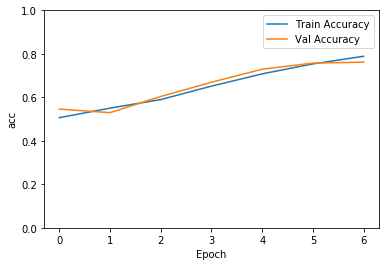

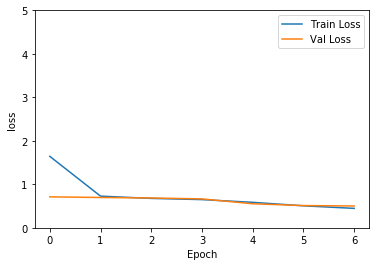

In [22]:
    #CNN Non Static Model wih hidden units = 150 and max seq = 52, and Learning rate =0.001  - - ignore warnings
    modelcnnnonstatic = main('cnn-non-static',150,52,0.001)
    history = modelcnnnonstatic.fit(np.array(listtrain), np.array(trainlabels), epochs=7,verbose=2, batch_size=512, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)

### CNN- Non-Static
#### Our train accuracy: 78.89%, Val Accuracy: 76.20% -for Hidden units = 512, DIM =300 and sequence length = 52

In [24]:
testpred = modelcnnnonstatic.predict_classes(np.array(listtest))
testacc =  modelcnnnonstatic.evaluate(np.array(listtest), np.array(testlabels))

2210/2210 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 180us/step
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


In [25]:
##Precision ##Recall ##F1 Measure
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(testlabels,testpred ).ravel()

In [26]:
#precision = tp/tp+fp
precision= tp/(tp+fp)

#recall = tp/tp+fn
recall = tp/(tp+fn)

f1score= 2*precision/(recall+precision)

In [30]:
print("Test Accuracy = ",testacc)
print("Precision = ", precision)
print("Recall = ", recall)
print("F1 Score = ", f1score)

Test Accuracy =  [0.49338148427764755, 0.7719457013574661]
Precision =  0.7444061962134251
Recall =  0.8069029850746269
F1 Score =  0.9597135183527304


#### Test Accuracy = 77.19%
#### Precision =  0.7444061962134251
#### Recall =  0.8069029850746269
#### F1 Score =  0.9597135183527304

### Conclusion:

#### We got an test accuracy of 77.2% and  F1 score of 96% on our testing data using our best model CNN-Non-static.
#### We got CNN-Non-Static model as our best model with Validation accuracy and training accuracy around 76.20% and 78.89% resepectively. Other models had high training accuracy compared to validation accuracy
#### Observed overfitting after epoch 4 in CNN-Rand and  CNN-Static model while CNN-Non-Static was tolerant to overfitting until 8 epochs. Overfitting issue is high in CNN-Rand model.
#### CNN -Static and CNN- Rand gave similar results in terms of Val accuracy around 70%.
#### As expected, CNN- Non-static performs better because of fine tuning to the dataset which carries information about test data as well. CNN-Rand performs better than CNN-Static by a little because its trained on this dataset and has learned a significant amount and has a training accuracy of around 85%. CNN-Static performs worse because we haven't trained it on the training set and the results get worse when dealing with more specific tasks.
#### Therefore, CNN-Non-Static was our best model and choice to use in cases of domain specific datasets.
